In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from matplotlib import  pyplot as plt
import requests
import folium
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
import json
import seaborn as sns
%matplotlib inline

# Introduction:
    The idea of this study is to help people planning to open a new restaurant in Haute-Savoie. It is the provience of France. This region has developed metropolitans. In order to chose the right location by providing data about the income and population of each neighborhood as well as the competitors already present on the same regions.

# Data:
    Haute-savoie population data is available in this site https://www.insee.fr/fr/statistiques/3689656#consulter Each commune or neighbourhood revenue(income) of Haute-savoie are avalilable on this site https://www.impots.gouv.fr/portail/statistiques The data is preprocessed by taking population column and code of all commune in Haute-savoie 2016. The income column is taking from impot.fr website . I merge these columns in one table and i used that table in my project. From geopy.geocoders i retrieve latitude and longitude of all commune amd append in my dataframe.

In [2]:
df = pd.read_excel(r"C:/Users/wajee/Downloads/commune de haute-savoie.xlsx",sheet_name='Figure 3')
df.head()

,Code commune,Commune,Population,Income
0,74001,Abondance,1408,3797589
1,74002,Alby-sur-Chéran,2580,3070608
2,74003,Alex,1052,1363040
3,74004,Allèves,409,403747
4,74005,Allinges,4433,5816560


In [3]:
df.rename(columns={'Code commune':'Code'},inplace=True)
df.head()

,Code,Commune,Population,Income
0,74001,Abondance,1408,3797589
1,74002,Alby-sur-Chéran,2580,3070608
2,74003,Alex,1052,1363040
3,74004,Allèves,409,403747
4,74005,Allinges,4433,5816560


### Geolocation-latitude-longitude

In [4]:
from geopy.geocoders import Nominatim
from opencage.geocoder import OpenCageGeocode
key = '9f253ab63bf746d7a976dbb47bf0a770'
geocoder = OpenCageGeocode(key)

address = 'Haute-savoie, France'  
results = geocoder.geocode(address)

print (results)

[{'annotations': {'DMS': {'lat': "46° 4' 7.75488'' N", 'lng': "6° 20' 40.33320'' E"}, 'MGRS': '32TKS9463905122', 'Maidenhead': 'JN36eb16im', 'Mercator': {'x': 706270.627, 'y': 5760599.275}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?relation=7407#map=17/46.06882/6.34454', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/46.06882/6.34454&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=46.06882&mlon=6.34454#map=17/46.06882/6.34454'}, 'UN_M49': {'regions': {'EUROPE': '150', 'FR': '250', 'WESTERN_EUROPE': '155', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 33, 'currency': {'alternate_symbols': [], 'decimal_mark': ',', 'html_entity': '&#x20AC;', 'iso_code': 'EUR', 'iso_numeric': '978', 'name': 'Euro', 'smallest_denomination': 1, 'subunit': 'Cent', 'subunit_to_unit': 100, 'symbol': '€', 'symbol_first': 0, 'thousands_separator': '.'}, 'flag': '🇫🇷', 'geohash': 'u0hw06efq6tstqgvvvhr', 'qibla': 120.77, 'roadinfo': {'drive_on': 'right', 'speed_

In [5]:
lat = results[0]['geometry']['lat']

lng = results[0]['geometry']['lng']

print (lat, lng)

46.0688208 6.344537


In [6]:
list_lat = []   # create empty lists

list_long = []


for index, row in df.iterrows(): # iterate over rows in datafram
    Code = row['Code'] 
    Commune = row['Commune']    
    query = str(Code)+','+str(Commune)

    results = geocoder.geocode(query)   
    lat = results[0]['geometry']['lat']
    long = results[0]['geometry']['lng']

    list_lat.append(lat)
    list_long.append(long)

# create new columns from lists    

df['lat'] = list_lat   

df['lon'] = list_long

### data frame:
 Append latitude and longitude of each commune with our preprocessed data set.

In [7]:
df.head()

,Code,Commune,Population,Income,lat,lon
0,74001,Abondance,1408,3797589,46.280661,6.719857
1,74002,Alby-sur-Chéran,2580,3070608,45.819054,6.020555
2,74003,Alex,1052,1363040,45.888900,6.237960
3,74004,Allèves,409,403747,45.751970,6.080210
4,74005,Allinges,4433,5816560,46.336782,6.464975


# FourSquare API:

### Get FoodCategory and FoodInformation

In [8]:
LIMIT = 500 # limit of number of venues returned by Foursquare API
radius = 2000 # define radius
CLIENT_ID = 'DV025IX5AIZQOW2BQO2ZZZ3HFPWTEGD5OYYHMNSKNJF5E0QA' # your Foursquare ID
CLIENT_SECRET = 'JIC0EJDFIUFC21EQ1N4ZISIOJU12LC2HYHA0ZZFPUY0MTV1U' # your Foursquare Secret
ACCESS_TOKEN = 'C3MT4JKKEOART2LU5XANYRQO4WFOZBBLEOOI2EUYHKT3ZHVM' # your FourSquare Access Token
VERSION = '20180604'
categoryFood ='4d4b7105d754a06374d81259'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DV025IX5AIZQOW2BQO2ZZZ3HFPWTEGD5OYYHMNSKNJF5E0QA
CLIENT_SECRET:JIC0EJDFIUFC21EQ1N4ZISIOJU12LC2HYHA0ZZFPUY0MTV1U


In [9]:
def getNearbyVenues(name, latitude, longitude, radius=2000, category=""):
    url = 'https://api.foursquare.com/v2/venues/search?&radius={}&'.format(radius)
    expand_infor = "client_id={}&client_secret={}&v={}&ll={},{}&limit={}".format(
        CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, LIMIT
    )
    
    if category:
        category_infor = "&categoryId={}".format(category)
    else:
        category_infor = ""
    # merge the url
    url = url + expand_infor + category_infor
    
    
    # extract infromation
    response = requests.get(url).json()
    
    return response

In [10]:
df["CategoryFood"] = df.apply(lambda x: getNearbyVenues(
        x["Commune"], x["lat"], x["lon"], category=categoryFood
    ), axis=1)

In [11]:
def get_category(x, target="category"):
    """
    parameters:
    ----------
    target: string, default category
        Choose target information. Like category, name, location
    """
    information = dict(
        Name = [],
        Location = [],
        Category = []
        )
    if "response" not in x or "venues" not in x["response"]:
        return np.nan
    for item in x["response"]["venues"]:
        name = item["name"]
        location = (item["location"]["lat"], item["location"]["lng"])
        category = item["categories"][0]["name"]
        
        if name and location and category:
            information["Name"].append(name)
            information["Location"].append(location)
            information["Category"].append(category)
    if target == "category":
        return information["Category"]
    elif target == "name":
        return information["Name"]
    elif target == "location":
        return information["Location"]
    elif target in ["all", ""]:
        return information

In [12]:
df["FoodInformation"] = df.CategoryFood.apply(get_category, target="all")

Append categoryfood and food information of each commune(neighbourhood) with our dataset. now we have coordinates of each neighbourhood along with their resturant information.

In [13]:
df.head()

,Code,Commune,Population,Income,lat,lon,CategoryFood,FoodInformation
0,74001,Abondance,1408,3797589,46.280661,6.719857,"{'meta': {'code': 200, 'requestId': '5fdf1002b...","{'Name': ['Hôtel-Restaurant du Port Yvoire', '..."
1,74002,Alby-sur-Chéran,2580,3070608,45.819054,6.020555,"{'meta': {'code': 200, 'requestId': '5fdf10026...","{'Name': ['Hôtel-Restaurant du Port Yvoire', '..."
2,74003,Alex,1052,1363040,45.888900,6.237960,"{'meta': {'code': 200, 'requestId': '5fdf10028...","{'Name': ['Hôtel-Restaurant du Port Yvoire', '..."
3,74004,Allèves,409,403747,45.751970,6.080210,"{'meta': {'code': 200, 'requestId': '5fdf10025...","{'Name': ['Hôtel-Restaurant du Port Yvoire', '..."
4,74005,Allinges,4433,5816560,46.336782,6.464975,"{'meta': {'code': 200, 'requestId': '5fdf10038...","{'Name': ['Hôtel-Restaurant du Port Yvoire', '..."


In [14]:
foodtype = set()
for i in df.FoodInformation:
    if pd.notna(i):
        j=json.dumps(i)
        i = json.loads(j)
        foodtype.update(set(i["Category"]))

In [15]:
foodtype = pd.Series(list(foodtype))
for column in foodtype[foodtype.str.contains("Restaurant", case=False)]:
    df[column] = df.FoodInformation.apply(lambda x: x["Category"].count(column) if pd.notna(x) else 0)

In [16]:
df.head(200)

,Code,Commune,Population,Income,lat,lon,CategoryFood,FoodInformation,Seafood Restaurant,French Restaurant,Swiss Restaurant,Restaurant
0,74001,Abondance,1408,3797589,46.280661,6.719857,"{'meta': {'code': 200, 'requestId': '5fdf1002b...","{'Name': ['Hôtel-Restaurant du Port Yvoire', '...",3,9,1,4
1,74002,Alby-sur-Chéran,2580,3070608,45.819054,6.020555,"{'meta': {'code': 200, 'requestId': '5fdf10026...","{'Name': ['Hôtel-Restaurant du Port Yvoire', '...",3,9,1,4
2,74003,Alex,1052,1363040,45.888900,6.237960,"{'meta': {'code': 200, 'requestId': '5fdf10028...","{'Name': ['Hôtel-Restaurant du Port Yvoire', '...",3,9,1,4
3,74004,Allèves,409,403747,45.751970,6.080210,"{'meta': {'code': 200, 'requestId': '5fdf10025...","{'Name': ['Hôtel-Restaurant du Port Yvoire', '...",3,9,1,4
4,74005,Allinges,4433,5816560,46.336782,6.464975,"{'meta': {'code': 200, 'requestId': '5fdf10038...","{'Name': ['Hôtel-Restaurant du Port Yvoire', '...",3,9,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
195,74220,Reignier-Ésery,7923,11407848,46.147763,6.233108,"{'meta': {'code': 200, 'requestId': '5fdf10346...","{'Name': ['Hôtel-Restaurant du Port Yvoire', '...",3,9,1,4
196,74221,Le Reposoir,515,865760,46.013300,6.533950,"{'meta': {'code': 200, 'requestId': '5fdf1034d...","{'Name': ['Hôtel-Restaurant du Port Yvoire', '...",3,9,1,4
197,74222,Reyvroz,513,699324,46.325760,6.558510,"{'meta': {'code': 200, 'requestId': '5fdf10357...","{'Name': ['Hôtel-Restaurant du Port Yvoire', '...",3,9,1,4
198,74223,La Rivière-Enverse,462,927825,46.092441,6.637400,"{'meta': {'code': 200, 'requestId': '5fdf10355...","{'Name': ['Hôtel-Restaurant du Port Yvoire', '...",3,9,1,4


In [17]:
# store data
if False:
    df.to_excel(r"C:/Users/wajee/Downloads/commune de haute-savoie.xlsx",sheet_name='Figure 3', index=False)

In [18]:
restaurant = df[
    df.columns[df.columns.str.contains("Restaurant", case=False)]
].sum()

# Display information:

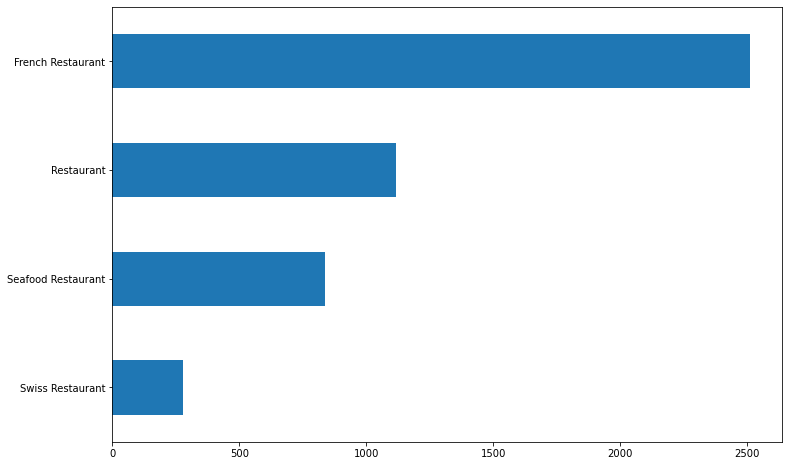

In [19]:
restaurant.sort_values().plot(kind="barh", figsize=(12, 8));

# Map information

In [47]:
df["AllRestarant"] = df[
    df.columns[df.columns.str.contains("Restaurant", case=False)]
].sum(axis=1)

In [48]:
foodlocation = []
for i in df["FoodInformation"]:
    if pd.notna(i):
        j=json.dumps(i)
        i = json.loads(j)
        foodlocation += i["Location"]

In [49]:
lat = results[0]['geometry']['lat']

lng = results[0]['geometry']['lng']

center = lat,lng
print(center)

(46.37028, 6.32615)


In [50]:
import folium
# create map of Haute-savoie using latitude and longitude values
map_hautesavoie = folium.Map(location=[lat, lng], zoom_start=8)
map_hautesavoie

In [51]:
folium.Marker(center, popup='Haute-Savoie').add_to(map_hautesavoie)

for lat, lng, sc, ar in zip(df["lat"], df["lon"],df["Population"], df["AllRestarant"]):
    if sc != 0:
        folium.CircleMarker([lat, lng], radius=sc * .2, color="blue", fill=True, 
                            fill_color="blue", fill_opacity=.3).add_to(map_hautesavoie)
    if ar != 0:
        folium.CircleMarker([lat, lng], radius=ar * .2, color="red", fill=True,
                           fill_color="red", fill_opacity=.3).add_to(map_hautesavoie)

map_hautesavoie

In [73]:
df.columns

Index(['Code', 'Commune', 'Population', 'Income', 'lat', 'lon', 'CategoryFood',
       'FoodInformation', 'Seafood Restaurant', 'French Restaurant',
       'Swiss Restaurant', 'Restaurant', 'AllRestarant'],
      dtype='object')

In [79]:
train_data = df.drop(["Commune", "CategoryFood", "FoodInformation"], axis=1)

# Create Cluster:
    We want to explore the number of cluster. So we use the KMeans algorithm to create model. Now we must check out how many clusters in the 289 candidate locations.

In [80]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
#import matplotlib.cm as cm
import numpy as np

For 2  Clusters  the average silhouette_score is : 0.8827256616998462
For 3  Clusters  the average silhouette_score is : 0.764692285672377
For 4  Clusters  the average silhouette_score is : 0.7602704533706617
For 5  Clusters  the average silhouette_score is : 0.7246773852201728
For 6  Clusters  the average silhouette_score is : 0.6813514376526735
For 7  Clusters  the average silhouette_score is : 0.6260674318405693
For 8  Clusters  the average silhouette_score is : 0.6657119244550718


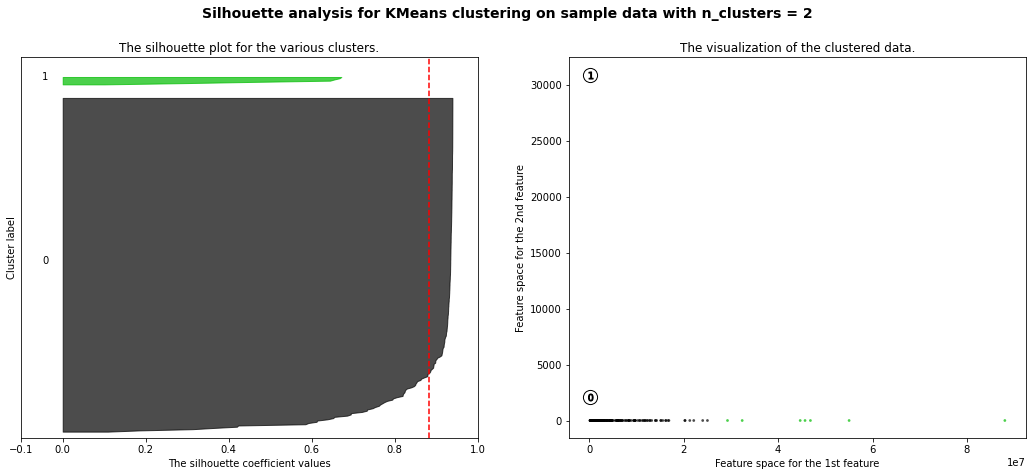

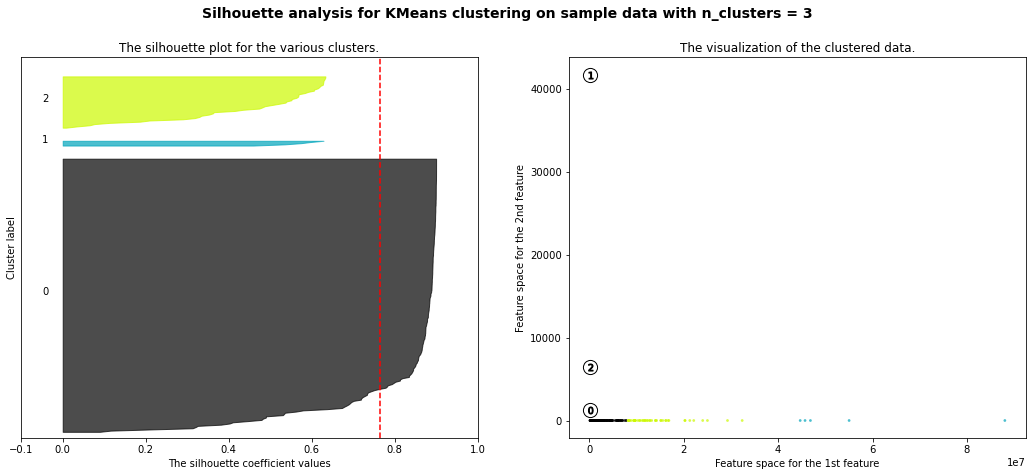

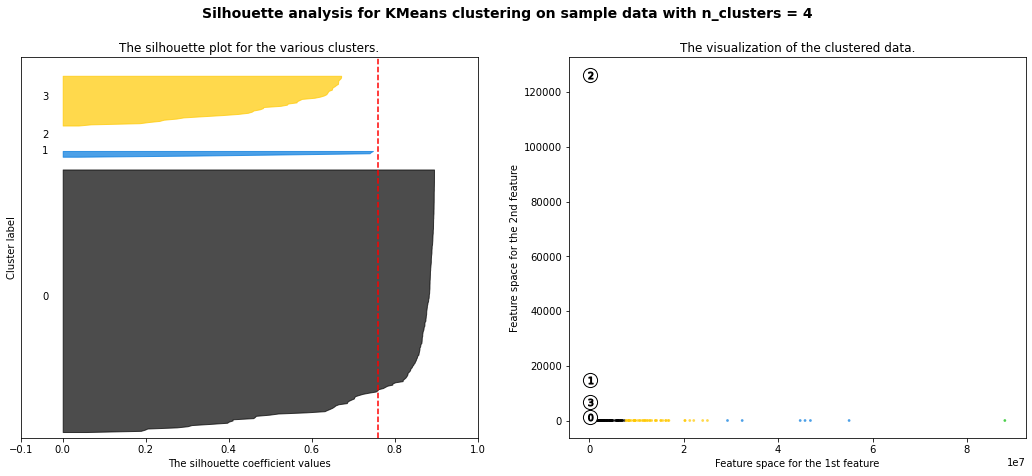

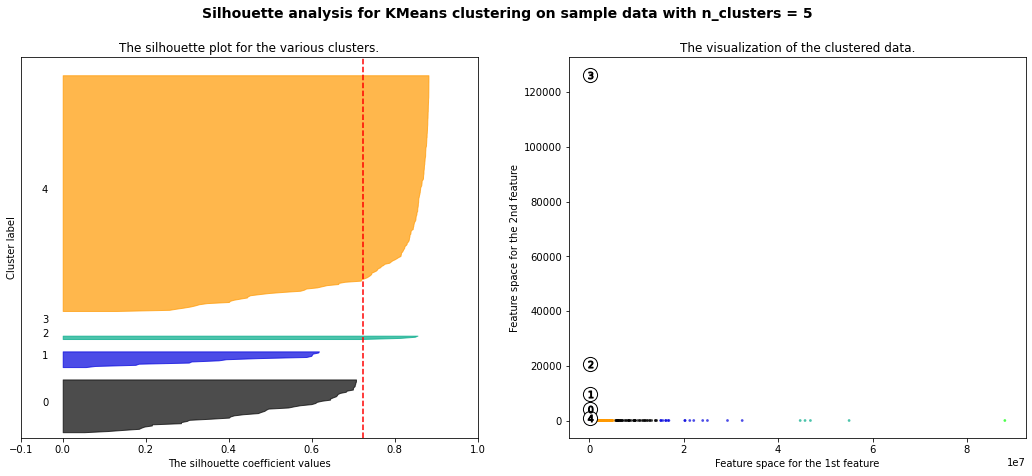

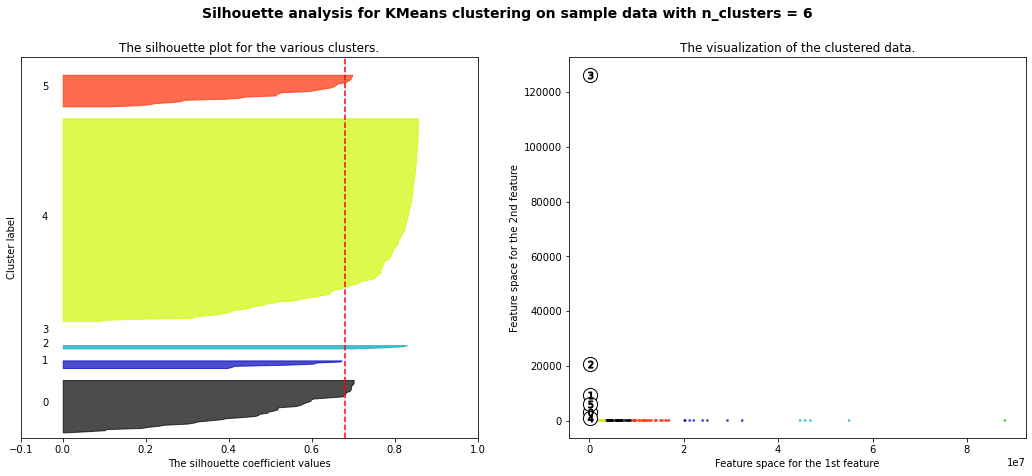

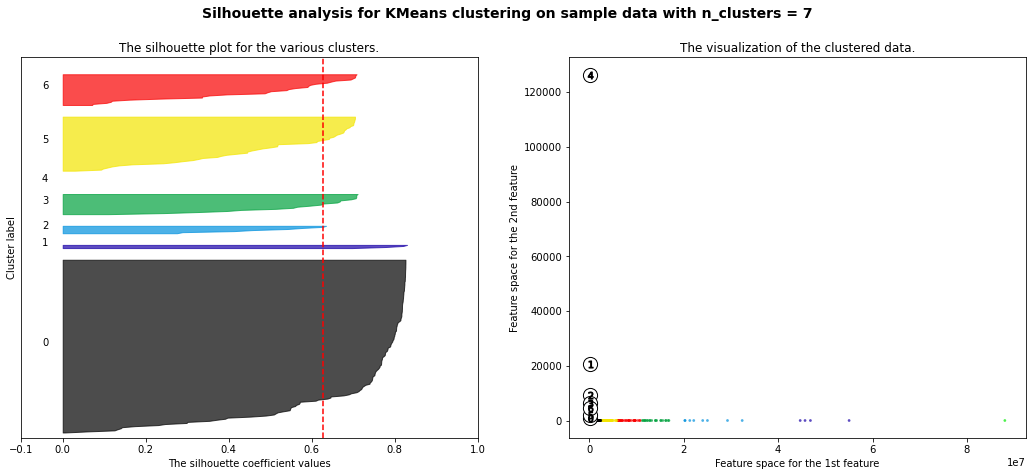

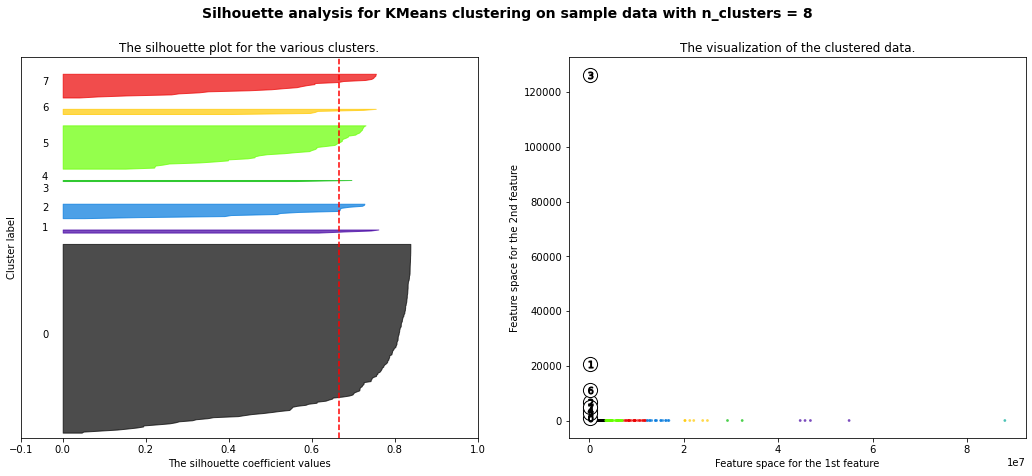

In [81]:
sse={}
for n_clusters in range(2, 9):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 
    
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(train_data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(train_data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(train_data, cluster_labels)
    print("For", n_clusters, " Clusters  "
          "the average silhouette_score is :", silhouette_avg)
    sse[n_clusters] = silhouette_avg
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(train_data, cluster_labels)

    y_lower = 5
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color1 = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color1, edgecolor=color1, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors2 = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(train_data.loc[:, "Income"],train_data.loc[:,"AllRestarant"], 
                marker='.', s=30, lw=0, alpha=0.7, c=colors2, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

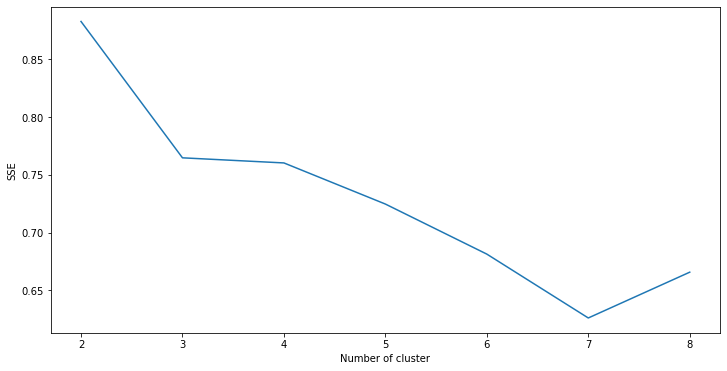

In [82]:
plt.figure(figsize=(12, 6))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [83]:
kclusters = 5
clusterer = KMeans(n_clusters=kclusters, random_state=10)
cluster_labels = clusterer.fit_predict(train_data)
train_data["Cluster"] = cluster_labels

In [84]:
train_data.Cluster.unique()

array([4, 0, 3, 2, 1])

In [85]:
train_data.shape

(279, 11)

In [86]:
train_data.head(200)

,Code,Population,Income,lat,lon,Seafood Restaurant,French Restaurant,Swiss Restaurant,Restaurant,AllRestarant,Cluster
0,74001,1408,3797589,46.280661,6.719857,3,9,1,4,17,4
1,74002,2580,3070608,45.819054,6.020555,3,9,1,4,17,4
2,74003,1052,1363040,45.888900,6.237960,3,9,1,4,17,4
3,74004,409,403747,45.751970,6.080210,3,9,1,4,17,4
4,74005,4433,5816560,46.336782,6.464975,3,9,1,4,17,0
...,...,...,...,...,...,...,...,...,...,...,...
195,74220,7923,11407848,46.147763,6.233108,3,9,1,4,17,0
196,74221,515,865760,46.013300,6.533950,3,9,1,4,17,4
197,74222,513,699324,46.325760,6.558510,3,9,1,4,17,4
198,74223,462,927825,46.092441,6.637400,3,9,1,4,17,4


## Cluster 1:

In [93]:
train_data.loc[train_data['Cluster'] == 0, train_data.columns[[1] + list(range(2, train_data.shape[1]))]]

,Population,Income,lat,lon,Seafood Restaurant,French Restaurant,Swiss Restaurant,Restaurant,AllRestarant,Cluster
4,4433,5816560,46.336782,6.464975,3,9,1,4,17,0
7,6302,11166567,46.196032,6.222457,3,9,1,4,17,0
11,2159,5533018,46.355762,6.427147,3,9,1,4,17,0
14,2571,5829957,46.135454,6.133246,3,9,1,4,17,0
21,5011,6130310,45.960415,6.040932,3,9,1,4,17,0
36,5563,7708614,46.264643,6.367104,3,9,1,4,17,0
55,1246,10710818,47.329208,6.364769,3,9,1,4,17,0
62,2653,6148673,46.326892,6.267459,3,9,1,4,17,0
72,1754,13993581,45.905200,6.423760,3,9,1,4,17,0
74,3958,9305015,46.140951,6.144953,3,9,1,4,17,0


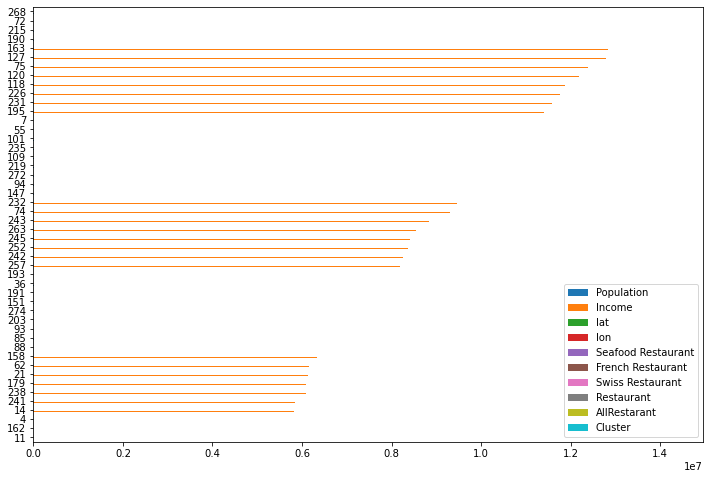

In [91]:
train_data.loc[train_data['Cluster'] == 0, train_data.columns[[1] + list(range(2, train_data.shape[1]))]].sort_values(by='Income').plot(kind="barh", figsize=(12, 8));

## Cluster 2:

In [95]:
train_data.loc[train_data['Cluster'] == 1, train_data.columns[[1] + list(range(2, train_data.shape[1]))]]

,Population,Income,lat,lon,Seafood Restaurant,French Restaurant,Swiss Restaurant,Restaurant,AllRestarant,Cluster
12,1921,15539644,46.043324,6.631786,3,9,1,4,17,1
35,12735,16160136,46.080200,6.407260,3,9,1,4,17,1
73,17371,22104479,46.060317,6.580422,3,9,1,4,17,1
83,6685,20213192,46.187460,6.291080,3,9,1,4,17,1
106,9074,16841010,46.400979,6.589793,3,9,1,4,17,1
117,11152,20268647,46.183844,6.211169,3,9,1,4,17,1
170,2827,21263714,46.181490,6.706640,3,9,1,4,17,1
185,10863,16671859,46.541284,4.534342,3,9,1,4,17,1
199,11795,15097073,46.067219,6.312166,3,9,1,4,17,1
200,15270,15170385,45.868730,5.936520,3,9,1,4,17,1


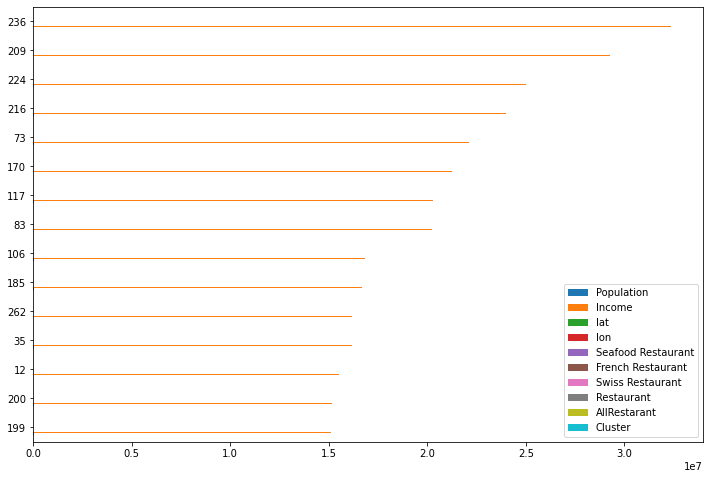

In [96]:
train_data.loc[train_data['Cluster'] == 1, train_data.columns[[1] + list(range(2, train_data.shape[1]))]].sort_values(by='Income').plot(kind="barh", figsize=(12, 8));

## Cluster 3:

In [97]:
train_data.loc[train_data['Cluster'] == 2, train_data.columns[[1] + list(range(2, train_data.shape[1]))]]

,Population,Income,lat,lon,Seafood Restaurant,French Restaurant,Swiss Restaurant,Restaurant,AllRestarant,Cluster
10,35041,44661654,46.193401,6.234109,3,9,1,4,17,2
48,8759,45686039,45.832706,6.865171,3,9,1,4,17,2
155,3123,46830727,45.852330,6.612860,3,9,1,4,17,2
246,35132,55026294,46.366670,6.483330,3,9,1,4,17,2


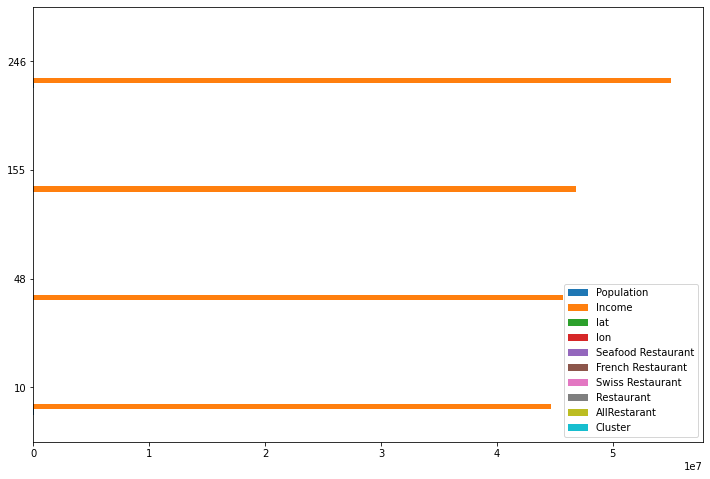

In [98]:
train_data.loc[train_data['Cluster'] == 2, train_data.columns[[1] + list(range(2, train_data.shape[1]))]].sort_values(by='Income').plot(kind="barh", figsize=(12, 8));

## Cluster 4:

In [99]:
train_data.loc[train_data['Cluster'] == 3, train_data.columns[[1] + list(range(2, train_data.shape[1]))]]

,Population,Income,lat,lon,Seafood Restaurant,French Restaurant,Swiss Restaurant,Restaurant,AllRestarant,Cluster
9,126419,88034065,45.899235,6.128885,3,9,1,4,17,3


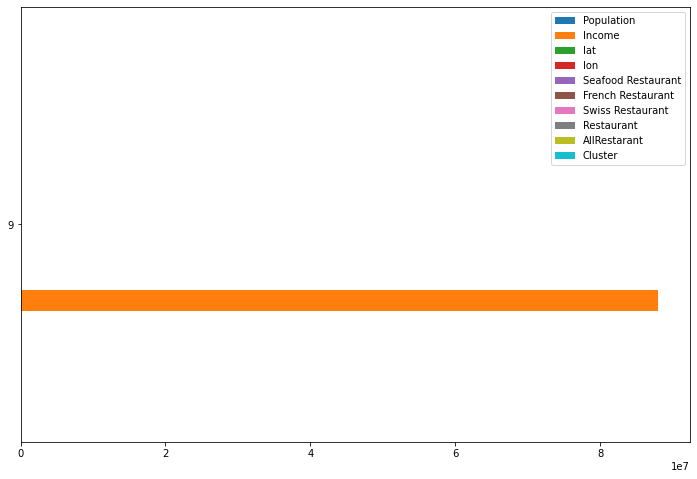

In [100]:
train_data.loc[train_data['Cluster'] == 3, train_data.columns[[1] + list(range(2, train_data.shape[1]))]].sort_values(by='Income').plot(kind="barh", figsize=(12, 8));

## Cluster 5:

In [101]:
train_data.loc[train_data['Cluster'] == 4, train_data.columns[[1] + list(range(2, train_data.shape[1]))]]

,Population,Income,lat,lon,Seafood Restaurant,French Restaurant,Swiss Restaurant,Restaurant,AllRestarant,Cluster
0,1408,3797589,46.280661,6.719857,3,9,1,4,17,4
1,2580,3070608,45.819054,6.020555,3,9,1,4,17,4
2,1052,1363040,45.888900,6.237960,3,9,1,4,17,4
3,409,403747,45.751970,6.080210,3,9,1,4,17,4
5,2042,2461211,46.000147,6.118553,3,9,1,4,17,4
...,...,...,...,...,...,...,...,...,...,...
273,1332,2009200,45.823331,6.058503,3,9,1,4,17,4
275,1532,2035122,46.103300,4.115990,3,9,1,4,17,4
276,458,549112,46.064396,6.137719,3,9,1,4,17,4
277,1541,2308682,46.101600,5.935940,3,9,1,4,17,4


In [76]:
map_hautesavoie = folium.Map(location= center, zoom_start=10, tiles="CartoDB dark_matter")
import matplotlib.colors as colors
# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(train_data['lat'], train_data['lon'], train_data['Cluster']):
    folium.CircleMarker(
        [lat, lon],
        radius=3,
#         popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_hautesavoie)
       
map_hautesavoie

# Conclusion:
    Our analysis shows that although there is a great number of restaurants in Haute-Savoie,the french food restaurant is main type close to city .the city close to Geneva border has much more food restaurant than the rest of communes who are away from the border. So, if we want to choose a appropriate location to open a new restaurant,we choose from the target.